In [74]:
import logging

import monai
import torch
from monai.data import CacheDataset, DataLoader, Dataset, ImageDataset
from monai.transforms import CastToTyped, RandFlipd, RandGaussianNoised, ScaleIntensityRanged, \
    Spacingd, Orientationd, LoadImaged, Compose, EnsureChannelFirstd, CropForegroundd, \
    Resized, EnsureTyped,ToTensord, RandFlipd, RandRotate90d, RandShiftIntensityd
from monai.data.utils import pad_list_data_collate
from torch.utils.data import random_split
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from kits23.configuration.paths import TRAINING_DIR
from kits23 import TRAINING_CASE_NUMBERS

from models import LightningUNet2

import matplotlib.pyplot as plt

In [75]:
images = [(TRAINING_DIR / f"case_{n:05d}" / "imaging.nii.gz").resolve(strict=True) for n in TRAINING_CASE_NUMBERS]
segs = [(TRAINING_DIR / f"case_{n:05d}" / "segmentation.nii.gz").resolve(strict=True) for n in TRAINING_CASE_NUMBERS]

train_files = [{"image": i, "label": l} for i, l in zip(images, segs)]

# images = [(TRAINING_DIR / f"case_{n:05d}" / "imaging.nii.gz").resolve(strict=True) for n in TRAINING_CASE_NUMBERS]
# segs = [(TRAINING_DIR / f"case_{n:05d}" / "segmentation.nii.gz").resolve(strict=True) for n in TRAINING_CASE_NUMBERS]
# val_files = [{"image": i, "label": l} for i, l in zip(val_images, val_labels)]
# data = open(r'./models/unets2/validation_cases.txt', 'r')
# cases = data.readlines()

# numbers = [int(case.split("/")[7].split("_")[1]) for case in cases]
# numbers

val_transform = Compose([LoadImaged(keys=["image", "label"]),
                         EnsureChannelFirstd(keys=["image", "label"]),
                         Orientationd(keys=["image", "label"], axcodes="RAS"),
                         Spacingd(keys=["image", "label"], pixdim=(1.62, 1.62, 2)),
                         ScaleIntensityRanged(keys="image", a_min=-80, a_max=305, b_min=0.0, b_max=1.0, clip=True,),
                         Resized(keys=["image", "label"], spatial_size=(160, 160, 128)),
                         ToTensord(keys=["image", "label"]),
                         EnsureTyped(keys=["image", "label"]),
                     ])

ds = Dataset(data=train_files, transform=val_transform)
complete_dl = DataLoader(ds, batch_size=1, collate_fn=pad_list_data_collate)

In [17]:
import nibabel as nib
import numpy as np
import os
from kits23.configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME, KITS_LABEL_TO_HEC_MAPPING
from kits23.evaluation.metrics import compute_metrics_for_label


model = LightningUNet2().load_from_checkpoint("models/unets2/lightning_logs/version_1/checkpoints/epoch=49-step=22000.ckpt")
metrics_for_every_case = []

model.eval()
with torch.no_grad():
    for case, batch in zip(TRAINING_CASE_NUMBERS, complete_dl):
        pred = model(batch["image"].cuda())
        pred = torch.argmax(pred, dim=1)
        
        metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        for i, hec in enumerate(HEC_NAME_LIST):
            metrics[i] = compute_metrics_for_label(pred.squeeze(0).cpu().numpy(), batch["label"].squeeze(0).squeeze(0).numpy(), KITS_HEC_LABEL_MAPPING[hec],
                                                   tuple((1.62, 1.62, 2)), sd_tolerance_mm=HEC_SD_TOLERANCES_MM[hec])
            
        metrics_for_every_case.append(metrics)

with open(r'./models/unets/evaluation.txt', 'w') as fp:
    for item in metrics_for_every_case:
        fp.write("%s\n" % item)
    print('Evaluation File written.')

Evaluation File written.


In [18]:
metrics_for_every_case

[array([[0.90163113, 0.77347889],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[0.91738357, 0.81404759],
        [0.23157895, 0.34440997],
        [0.23157895, 0.34440997]]),
 array([[0.74622595, 0.59633693],
        [0.27706821, 0.28678639],
        [0.13294128, 0.20077005]]),
 array([[0.92452676, 0.79688323],
        [0.79514416, 0.6752429 ],
        [0.77279753, 0.64900934]]),
 array([[0.89054169, 0.76144436],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[0.62691785, 0.51635398],
        [0.76791347, 0.55209963],
        [0.76860622, 0.55366085]]),
 array([[0.89395667, 0.79036305],
        [0.74336283, 0.66584957],
        [0.81481481, 0.73702864]]),
 array([[0.92494051, 0.8090856 ],
        [0.85491217, 0.71368214],
        [0.        , 0.01378273]]),
 array([[0.71361344, 0.44668938],
        [0.59670608, 0.29425687],
        [0.6151502 , 0.30586353]]),
 array([[0.90483032, 0.69661651],
        [0.51590106, 0.3328853

In [31]:
dice_kidney = []
dice_masses = []
dice_tumor = []
s_dice_kidney = []
s_dice_masses = []
s_dice_tumor = []

for metrics in metrics_for_every_case: 
    dice_kidney.append(metrics[0][0])
    dice_masses.append(metrics[1][0])
    dice_tumor.append(metrics[2][0])
    s_dice_kidney.append(metrics[0][1])
    s_dice_masses.append(metrics[1][1])
    s_dice_tumor.append(metrics[2][1])

print(np.mean(dice_kidney), np.std(dice_kidney), max(dice_kidney), min(dice_kidney))
print(np.percentile(dice_kidney, [50, 25, 10, 5]))
print(np.mean(dice_masses),np.std(dice_masses), max(dice_masses), min(dice_masses))
print(np.percentile(dice_masses, [50, 25, 10, 5]))
print(np.mean(dice_tumor), np.std(dice_tumor), max(dice_tumor), min(dice_tumor))
print(np.percentile(dice_tumor, [50, 25, 10, 5]))
print(np.mean(s_dice_kidney), np.std(s_dice_kidney), max(s_dice_kidney), min(s_dice_kidney))
print(np.percentile(s_dice_kidney, [50, 25, 10, 5]))
print(np.mean(s_dice_masses), np.std(s_dice_masses), max(s_dice_masses), min(s_dice_masses))
print(np.percentile(s_dice_masses, [50, 25, 10, 5]))
print(np.mean(s_dice_tumor), np.std(s_dice_tumor), max(s_dice_tumor), min(s_dice_tumor))
print(np.percentile(s_dice_tumor, [50, 25, 10, 5]))

0.8723096422892576 0.12015439059694269 0.9665625563446226 0.0
[0.899749   0.87484383 0.82201184 0.72465061]
0.5987082770917387 0.3120278958218529 0.971003372028356 0.0
[0.72865275 0.43125    0.         0.        ]
0.5202359435541357 0.3391444387697573 1.0 0.0
[0.64812576 0.15384615 0.         0.        ]
0.7095612385518987 0.1383437395795174 0.8985704367212247 0.0
[0.7373102  0.66217829 0.5511619  0.48254189]
0.42589985628422866 0.23873213382314137 0.8899666293553102 0.0
[0.47265025 0.27158925 0.         0.        ]
0.38028338606362755 0.2525154397938152 1.0 0.0
[0.42511909 0.13968841 0.         0.        ]


[[0.92494051 0.8090856 ]
 [0.85491217 0.71368214]
 [0.         0.01378273]]


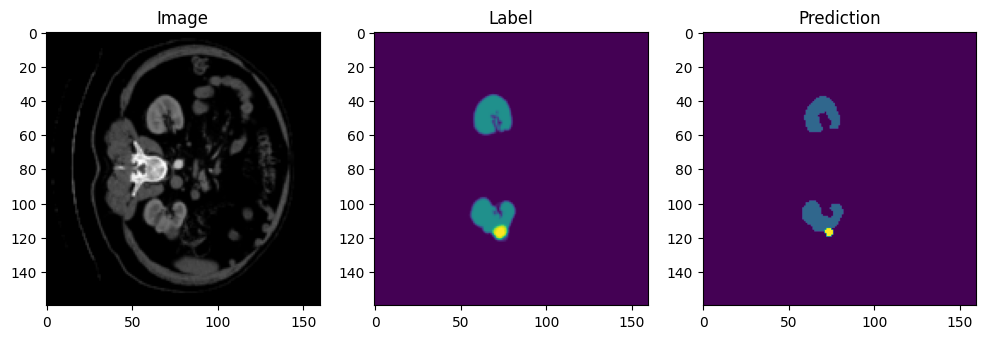

[[0.96656256 0.78901415]
 [0.97100337 0.75804021]
 [0.8930508  0.66626248]]


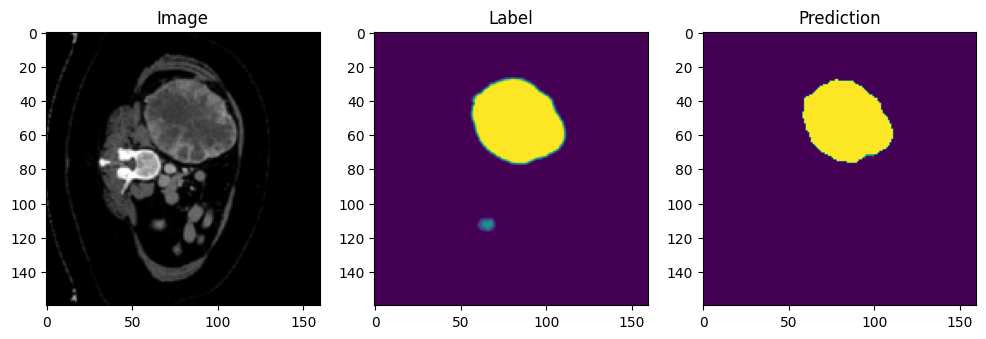

[[0.9220221  0.67296809]
 [0.94146995 0.64832319]
 [0.84989893 0.53502754]]


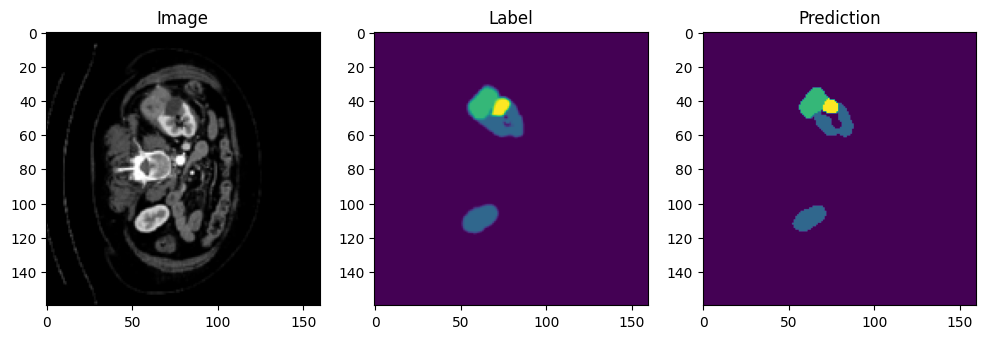

In [83]:
import nibabel as nib
import numpy as np
import os
from kits23.configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME, KITS_LABEL_TO_HEC_MAPPING
from kits23.evaluation.metrics import compute_metrics_for_label


selected_samples = (7, 67, 102) # good predictions
images = [(TRAINING_DIR / f"case_{n:05d}" / "imaging.nii.gz").resolve(strict=True) for n in selected_samples]
segs = [(TRAINING_DIR / f"case_{n:05d}" / "segmentation.nii.gz").resolve(strict=True) for n in selected_samples]

selected_files = [{"image": i, "label": l} for i, l in zip(images, segs)]

selected_ds = Dataset(data=selected_files, transform=val_transform)
selected_dl = DataLoader(selected_ds, batch_size=1, collate_fn=pad_list_data_collate)

model = LightningUNet2().load_from_checkpoint("models/unets2/lightning_logs/version_1/checkpoints/epoch=49-step=22000.ckpt")

model.eval()
with torch.no_grad():
    for batch in selected_dl:
        pred = model(batch["image"].cuda())
        pred = torch.argmax(pred, dim=1)
        
        metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        for i, hec in enumerate(HEC_NAME_LIST):
            metrics[i] = compute_metrics_for_label(pred.squeeze(0).cpu().numpy(), batch["label"].squeeze(0).squeeze(0).numpy(), KITS_HEC_LABEL_MAPPING[hec],
                                                   tuple((1.62, 1.62, 2)), sd_tolerance_mm=HEC_SD_TOLERANCES_MM[hec])
            
        print(metrics)
        
        plt.figure("check", (12, 18))

        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(batch["image"][0, 0, :, :, 40], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(batch["label"][0, 0, :, :, 40])

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred.cpu().detach()[0, :, :, 40])

        plt.show()

In [98]:
selected_samples = (7, 67, 102) # good predictions
images = [(TRAINING_DIR / f"case_{n:05d}" / "imaging.nii.gz").resolve(strict=True) for n in selected_samples]
segs = [(TRAINING_DIR / f"case_{n:05d}" / "segmentation.nii.gz").resolve(strict=True) for n in selected_samples]
preds = [f"nnunet/results/3d/case_{n:05d}.nii.gz" for n in selected_samples]

pred_transform = Compose([LoadImaged(keys=["image", "label", "3d_prediction"]),
                         EnsureChannelFirstd(keys=["image", "label", "3d_prediction"]),
                         Orientationd(keys=["image", "label", "3d_prediction"], axcodes="RAS"),
                         ScaleIntensityRanged(keys="image", a_min=-80, a_max=305, b_min=0.0, b_max=1.0, clip=True,),
                         Resized(keys=["image", "label"], spatial_size=(160, 160, 128)),
                         ])

selected_files = [{"image": i, "label": l, "3d_prediction": p} for i, l, p in zip(images, segs, preds)]
selected_ds = Dataset(data=selected_files, transform=pred_transform)
selected_dl = DataLoader(selected_ds, batch_size=1, collate_fn=pad_list_data_collate)

torch.Size([1, 1, 512, 512, 61])


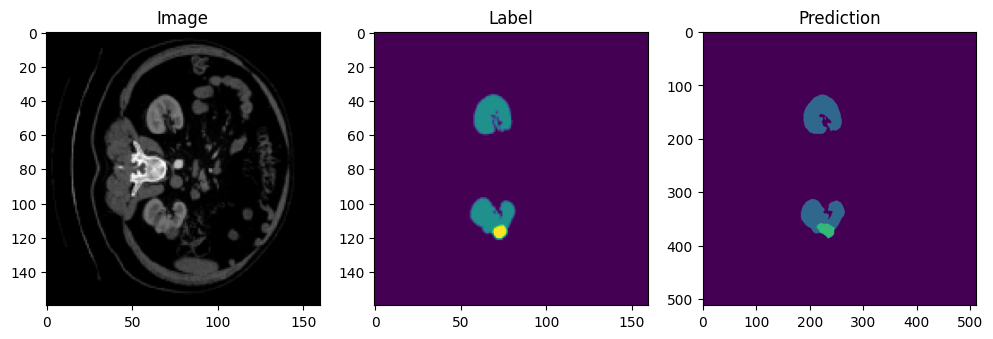

torch.Size([1, 1, 512, 512, 285])


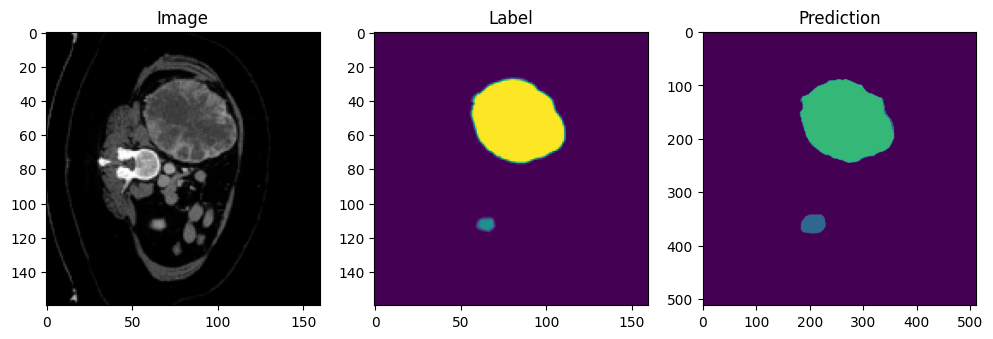

torch.Size([1, 1, 512, 512, 316])


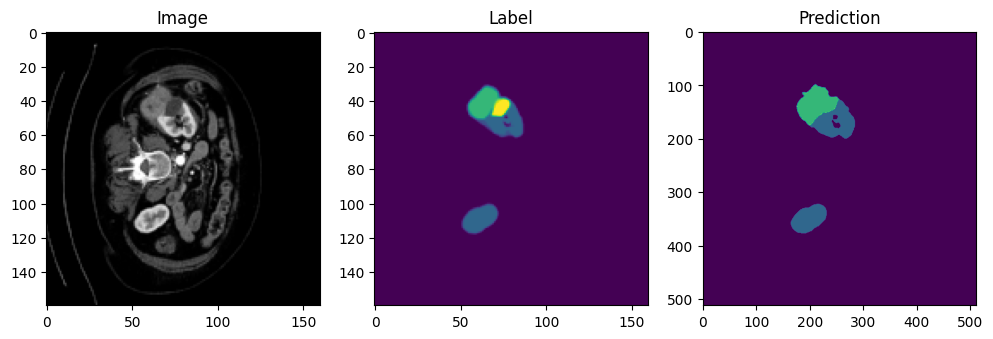

In [117]:
iter_obj = iter(selected_dl)
prediction_batch = next(iter_obj)  
print(prediction_batch["3d_prediction"].size())
plt.figure("check", (12, 18))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(prediction_batch["image"][0, 0, :, :, 40], cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(prediction_batch["label"][0, 0, :, :, 40])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction_batch["3d_prediction"][0, 0, :, :, 18])

plt.show()

prediction_batch = next(iter_obj) 
print(prediction_batch["3d_prediction"].size())
plt.figure("check", (12, 18))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(prediction_batch["image"][0, 0, :, :, 40], cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(prediction_batch["label"][0, 0, :, :, 40])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction_batch["3d_prediction"][0, 0, :, :, 95])

plt.show()

prediction_batch = next(iter_obj) 
print(prediction_batch["3d_prediction"].size())
plt.figure("check", (12, 18))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(prediction_batch["image"][0, 0, :, :, 40], cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(prediction_batch["label"][0, 0, :, :, 40])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction_batch["3d_prediction"][0, 0, :, :, 100])

plt.show()

torch.Size([1, 1, 512, 512, 285])


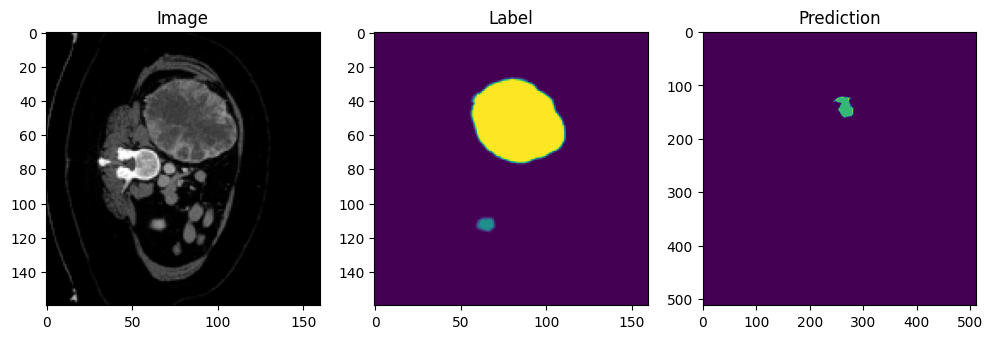

In [111]:
prediction_batch = next(iter_obj) 
print(prediction_batch["3d_prediction"].size())
plt.figure("check", (12, 18))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(prediction_batch["image"][0, 0, :, :, 40], cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(prediction_batch["label"][0, 0, :, :, 40])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction_batch["3d_prediction"][0, 0, :, :, 18])

plt.show()

In [86]:
prediction_batch["3d_prediction"].size(), prediction_batch["label"].size()

(torch.Size([1, 1, 512, 512, 316]), torch.Size([1, 1, 512, 512, 316]))

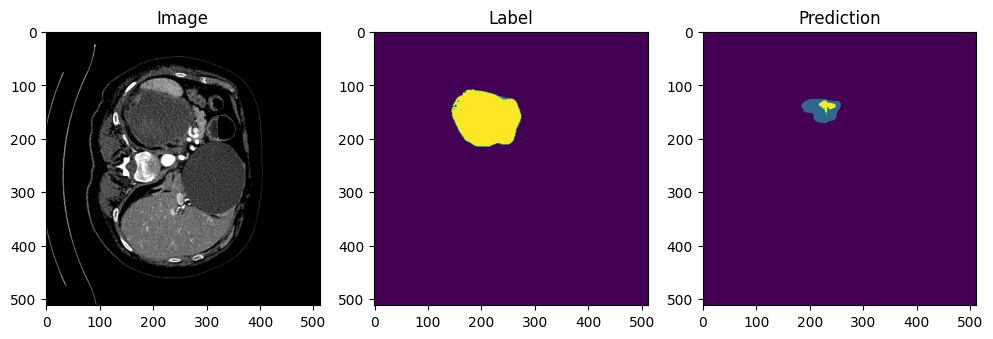

In [96]:
plt.figure("check", (12, 18))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(prediction_batch["image"][0, 0, :, :, 190], cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(prediction_batch["label"][0, 0, :, :, 190])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction_batch["3d_prediction"][0, 0, :, :, 190])

plt.show()

In [64]:
nn_dice_kidney = []
nn_dice_masses = []
nn_dice_tumor = []
nn_s_dice_kidney = []
nn_s_dice_masses = []
nn_s_dice_tumor = []

In [70]:
import csv
with open('nnunet/results/3d/evaluation.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(csv_reader):
        if i == 0 or i == 492:
            continue
        items = [float(n) for n in row[0].split(',')[1:]]
        nn_dice_kidney.append(items[0])
        nn_dice_masses.append(items[1])
        nn_dice_tumor.append(items[2])
        nn_s_dice_kidney.append(items[3])
        nn_s_dice_masses.append(items[4])
        nn_s_dice_tumor.append(items[5])
        

In [73]:
import numpy as np
print(np.mean(nn_dice_kidney), np.std(nn_dice_kidney), max(nn_dice_kidney), min(nn_dice_kidney))
print(np.percentile(nn_dice_kidney, [50, 25, 10, 5]))
print(np.mean(nn_dice_masses),np.std(nn_dice_masses), max(nn_dice_masses), min(nn_dice_masses))
print(np.percentile(nn_dice_masses, [50, 25, 10, 5]))
print(np.mean(nn_dice_tumor), np.std(nn_dice_tumor), max(nn_dice_tumor), min(nn_dice_tumor))
print(np.percentile(nn_dice_tumor, [50, 25, 10, 5]))
print(np.mean(nn_s_dice_kidney), np.std(nn_s_dice_kidney), max(nn_s_dice_kidney), min(nn_s_dice_kidney))
print(np.percentile(nn_s_dice_kidney, [50, 25, 10, 5]))
print(np.mean(nn_s_dice_masses), np.std(nn_s_dice_masses), max(nn_s_dice_masses), min(nn_s_dice_masses))
print(np.percentile(nn_s_dice_masses, [50, 25, 10, 5]))
print(np.mean(nn_s_dice_tumor), np.std(nn_s_dice_tumor), max(nn_s_dice_tumor), min(nn_s_dice_tumor))
print(np.percentile(nn_s_dice_tumor, [50, 25, 10, 5]))

0.9328989387551021 0.06761813746192123 0.98109526 0.4665027
[0.95911302 0.93205203 0.8559405  0.79891739]
0.7031422286734693 0.2498509632690047 0.96999374 0.0
[0.79117215 0.63502233 0.28817459 0.06739741]
0.6627633881020408 0.28179237017547276 0.96870161 0.0
[0.77895332 0.52484644 0.14298708 0.01064639]
0.8534673695918368 0.1194234287420123 0.97994021 0.25816545
[0.89457005 0.81055808 0.69042222 0.610709  ]
0.497950705244898 0.22000605005077364 0.90663518 0.0
[0.54554909 0.35231717 0.17216375 0.04568811]
0.4758093231428571 0.23826628095758895 0.90990098 0.0
[0.51492253 0.30557802 0.10133142 0.02035431]
